<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading df
traincsv = pd.read_csv('train.csv')

In [3]:
#chacking if any null values in given graph 
traincsv[traincsv.isna().any(1)]

,source_node,destination_node


In [4]:
#info of given data set
traincsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB


In [5]:
#no of duplicates
sum(traincsv.duplicated())

0

In [6]:
#removing header and saving
traincsv.to_csv('train_woheader.csv',header=False,index=False)

In [2]:
#Getting basic info from our data
g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


## EDA

In [8]:
# No of Unique persons 
len(g.nodes())

1862220

##### No of followers for each person

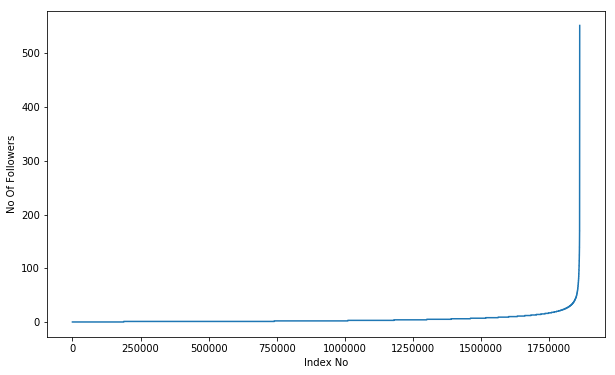

In [9]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

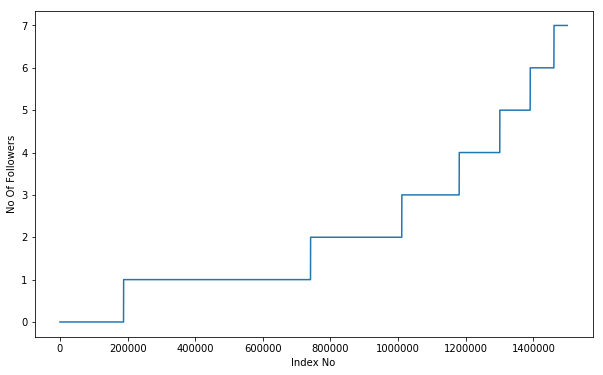

In [10]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

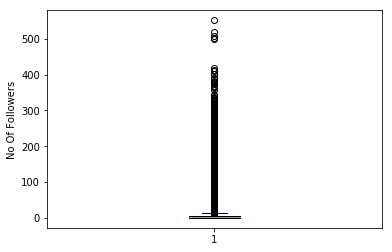

In [11]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [12]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers of 40 only.

In [13]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


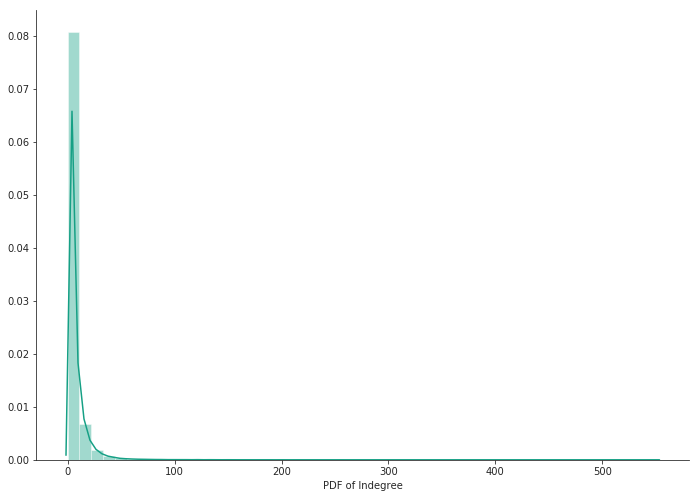

In [14]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

##### No of people each person is following

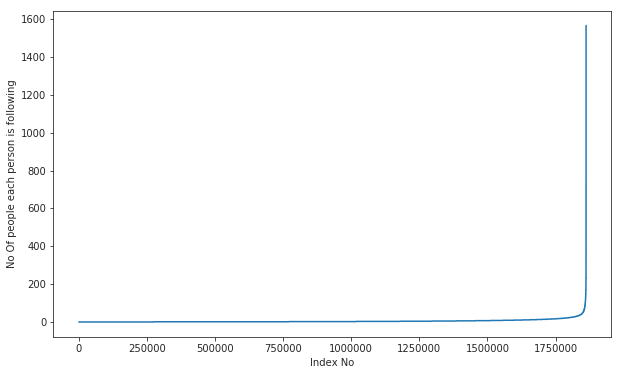

In [15]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

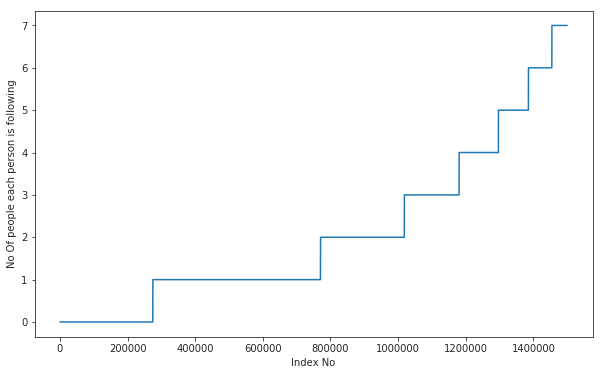

In [16]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

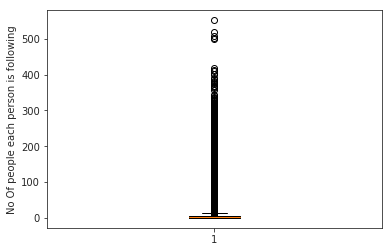

In [17]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [18]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [19]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


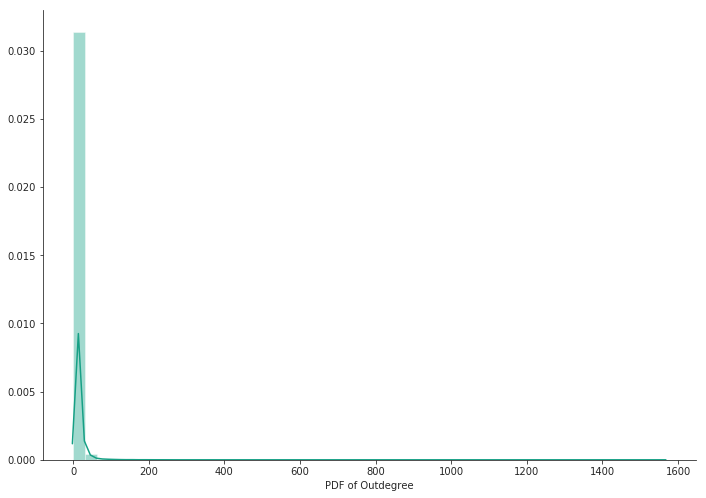

In [20]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [21]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [22]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [23]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


##### both followers + following 

In [24]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

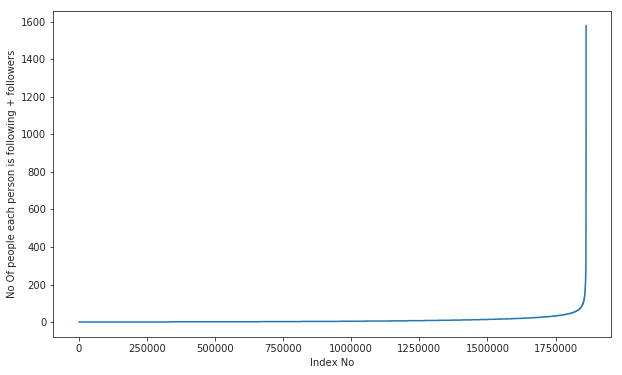

In [25]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

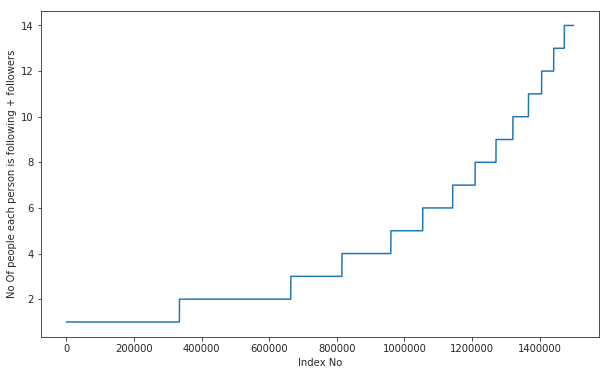

In [26]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [27]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [28]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [29]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [30]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [31]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [32]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


#### Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [4]:
#getting all set of edges
r = csv.reader(open('train_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

In [6]:
%%time
###generating bad edges from given graph
import random
missing_edges = set([])
while (len(missing_edges)<9437519):
    a=random.randint(1, 1862220)
    b=random.randint(1, 1862220)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
        try:
            if nx.shortest_path_length(g,source=a,target=b) > 2: 
                
                missing_edges.add((a,b))
            else:
                continue  
        except:  
                missing_edges.add((a,b))              
    else:
        continue

CPU times: user 2h 28min 24s, sys: 34.8 s, total: 2h 28min 59s
Wall time: 2h 28min 59s


In [7]:
len(missing_edges)

9437519

In [8]:
import pickle
pickle.dump(missing_edges,open('missing_edges_final.p','wb'))

In [45]:
import pickle
missing_edges = pickle.load(open('missing_edges_final.p','rb'))

#### Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [46]:
#reading total data df
df_pos = pd.read_csv('train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

In [47]:
#positive links i.e graph
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB


In [48]:
#negative links synthesized links
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB


In [49]:
#Trian test split 
#Spiltted data into 80-20 
#positive links and negative links seperatly because we need positive training data only for creating graph 
#and for feature generation
from sklearn.model_selection import train_test_split
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

In [50]:
df_train_pos = pd.DataFrame(X_train_pos)
#removing header and saving
df_train_pos.to_csv('train_data.csv',header=False,index=False)

In [51]:
#Graph from Traing data only 
g=nx.read_edgelist('train_data.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [52]:
#Graph of total data without splitting 
G=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


In [53]:
###total nodes in train positive data
train_nodes_pos = set(g.nodes())
###total nodes in total data
total_nodes_pos = set(G.nodes())
###test nodes in pos data
test_nodes_pos = set(X_test_pos.values.flatten())

In [11]:
print('no of people common in train and test -- ',len(train_nodes_pos.intersection(test_nodes_pos)))
print('no of people present in train but not present in test -- ',len(train_nodes_pos - test_nodes_pos))
print('no of people present in test but not present in train -- ',len(test_nodes_pos - train_nodes_pos))

no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498


In [57]:
print(' % of people not there in Train but exist in Test in total Test data are {} %'.\
                  format(len(test_nodes_pos - train_nodes_pos)/len(test_nodes_pos)*100))

 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


This will cause a cold start problem

In [13]:
#final train and test data sets
df_final_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_final_train = np.concatenate((y_train_pos,y_train_neg))
df_final_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_final_test = np.concatenate((y_test_pos,y_test_neg))

In [14]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100030 entries, 0 to 15100029
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 230.4 MB


In [15]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775008 entries, 0 to 3775007
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 57.6 MB


#### Adjacency_matrix   
https://en.wikipedia.org/wiki/Adjacency_matrix

In [7]:
Adj = nx.adjacency_matrix(g,nodelist=sorted(g.nodes()))

In [8]:
Adj = Adj.asfptype()
Adj

<1780722x1780722 sparse matrix of type '<class 'numpy.float64'>'
	with 7550015 stored elements in Compressed Sparse Row format>

## Feature Engineering

### SVD

In [9]:
from scipy.sparse.linalg import svds, eigs
U, s, V = svds(Adj,k = 6)

In [10]:
U

array([[-2.06311438e-15,  4.86280646e-12,  4.32863386e-13,
         6.34827889e-14,  1.18649118e-14,  1.85940576e-16],
       [-5.39810495e-14,  7.68601596e-13,  1.32207398e-11,
         2.12945529e-13,  9.80313275e-13,  5.21376923e-16],
       [-1.03323961e-11,  2.77939874e-11,  1.56793759e-09,
         2.35993376e-11,  3.87897382e-12,  6.99955573e-13],
       ...,
       [-9.08926368e-15,  3.01073958e-14,  6.61712281e-13,
         1.86989518e-13,  2.39751694e-12,  1.01911935e-14],
       [-4.04926290e-13,  1.66308893e-13,  1.36923604e-06,
         6.08332634e-14,  1.84662990e-13,  1.79395445e-12],
       [-7.33024975e-15,  7.79261880e-15,  7.97714296e-14,
         2.89269174e-16,  1.21312591e-15,  2.25623613e-16]])

In [11]:
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [12]:
del Adj
del s

### Similarity measures

#### Jaccard Distance:

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [21]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/\
                                    (len(set(g.successors(a)).union(set(g.successors(b)))))
    except:
        return 0
    return sim

In [22]:
#one test case
jaccard_for_followees(2,1615927)

0.0

In [23]:
#node 1635354 not in graph 
jaccard_for_followees(669354,1635354)

0

In [24]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/\
                                 (len(set(g.predecessors(a)).union(set(g.predecessors(b)))))
        return sim
    except:
        return 0

In [25]:
jaccard_for_followers(2,470294)

0.045454545454545456

In [26]:
#node 1635354 not in graph 
jaccard_for_followees(669354,1635354)

0

#### Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [27]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/\
                                    (math.sqrt(len(set(g.successors(a)))*len((set(g.successors(b))))))
        return sim
    except:
        return 0

In [28]:
cosine_for_followees(2,470294)

0.08944271909999159

In [29]:
cosine_for_followees(669354,1635354)

0

In [30]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/\
                                     (math.sqrt(len(set(g.predecessors(a))))*(len(set(g.predecessors(b)))))
        return sim
    except:
        return 0

In [31]:
cosine_for_followers(2,470294)

0.02886751345948129

In [32]:
cosine_for_followers(669354,1635354)

0

### Ranking Measures

https://en.wikipedia.org/wiki/PageRank

In [33]:
pr = nx.pagerank(g, alpha=0.85)

In [34]:
pickle.dump(pr,open('page_rank.p','wb'))

In [35]:
len(pr)

1780722

In [37]:
pr = pickle.load(open('page_rank.p','rb'))

In [39]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [40]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)

#### Shortest path:

Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [8]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if g.has_edge(a,b):
            g.remove_edge(a,b)
            p= nx.shortest_path_length(g,source=a,target=b)
            g.add_edge(a,b)
        else:
            p= nx.shortest_path_length(g,source=a,target=b)
        return p
    except:
        return -1

In [9]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [10]:
#testing
compute_shortest_path_length(669354,1635354)

-1

#### Checking for same community

In [39]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(g))
def belongs_to_same_wcc(a,b):
    index = []
    if g.has_edge(b,a):
        return 1
    if g.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                g.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    g.add_edge(a,b)
                    return 0
                else:
                    g.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [40]:
belongs_to_same_wcc(861, 1659750)

0

In [41]:
belongs_to_same_wcc(669354,1635354)

0

#### Adamic/Adar Index

\begin{equation}
A = \displaystyle\sum_{u\in N(x)\cap N(y)} \frac{1}{log|N(u)|} 
\end{equation}

In [42]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(g.successors(a)).intersection(set(g.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(g.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [43]:
calc_adar_in(1,189226)

0

In [44]:
calc_adar_in(669354,1635354)

0

#### Is persion was following back:

In [45]:
def follows_back(a,b):
    if g.has_edge(b,a):
        return 1
    else:
        return 0

In [46]:
follows_back(1,189226)

1

In [47]:
follows_back(669354,1635354)

0

#### Katz Centrality:

https://en.wikipedia.org/wiki/Katz_centrality

In [119]:
katz = nx.katz.katz_centrality(g,alpha=0.005,beta=1)
#import pickle
#katz = pickle.load(open('katz.p','rb'))

In [11]:
import pickle
katz = pickle.load(open('katz.p','rb'))

In [24]:
type(katz)

dict

In [32]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [33]:
mean_katz = float(sum(katz.values())) / len(katz)

#### Hits Score

https://en.wikipedia.org/wiki/HITS_algorithm

In [40]:
hits = nx.hits(g, max_iter=100, tol=1e-08, nstart=None, normalized=True)
#hits = pickle.load(open('hits.p','rb'))

In [13]:
hits = pickle.load(open('hits.p','rb'))

In [14]:
len(hits)

2

In [15]:
len(hits[0])

1780722

In [45]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


In [43]:
import pickle
pickle.dump(hits,open('hits.p','wb'))

##### From all above scores preparing data set 

In [54]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100030 entries, 0 to 15100029
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 230.4 MB


In [55]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775008 entries, 0 to 3775007
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 57.6 MB


In [57]:
#mapping jaccrd followers to train data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                        jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

In [59]:
#mapping jaccrd followers to test data
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                        jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

In [60]:
#mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                        jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                        jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)

In [65]:
#calculating no of followers followees for source and destination
#calculating intersection of followers and followees for source and destination
num_followers_s=[]
num_followees_s=[]
num_followers_d=[]
num_followees_d=[]
inter_followers=[]
inter_followees=[]
for i,row in df_final_train.iterrows():
    try:
        s1=set(g.predecessors(row['source_node']))
        s2=set(g.successors(row['source_node']))
    except:
        s1 = set()
        s2 = set()
    try:
        d1=set(g.predecessors(row['destination_node']))
        d2=set(g.successors(row['destination_node']))
    except:
        d1 = set()
        d2 = set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

In [66]:
df_final_train['num_followers_s']=num_followers_s
df_final_train['num_followees_s']=num_followees_s
df_final_train['num_followers_d']=num_followers_d
df_final_train['num_followees_d']=num_followees_d
df_final_train['inter_followers']=inter_followers
df_final_train['inter_followees']=inter_followees

In [67]:
#For test data
#calculating no of followers followees for source and destination
#calculating intersection of followers and followees for source and destination
num_followers_s=[]
num_followees_s=[]
num_followers_d=[]
num_followees_d=[]
inter_followers=[]
inter_followees=[]
for i,row in df_final_test.iterrows():
    try:
        s1=set(g.predecessors(row['source_node']))
        s2=set(g.successors(row['source_node']))
    except:
        s1 = set()
        s2 = set()
    try:
        d1=set(g.predecessors(row['destination_node']))
        d2=set(g.successors(row['destination_node']))
    except:
        d1 = set()
        d2 = set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

In [68]:
#assigning
df_final_test['num_followers_s']=num_followers_s
df_final_test['num_followees_s']=num_followees_s
df_final_test['num_followers_d']=num_followers_d
df_final_test['num_followees_d']=num_followees_d
df_final_test['inter_followers']=inter_followers
df_final_test['inter_followees']=inter_followees

In [69]:
#saving to disk 
df_final_train.to_csv('df_final_train_some.csv',index=False)
df_final_test.to_csv('df_final_test_some.csv',index=False)

In [71]:
#head of df 
df_final_train.head()

,source_node,destination_node,jaccard_followers,jaccard_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees
0,273084,1505602,0.000000,0.000000,11,15,6,8,0,0
1,912810,1678443,0.058824,0.058824,10,10,8,8,1,1
2,365429,1523458,0.033058,0.023077,40,49,85,84,4,3
3,527014,1605979,0.000000,0.000000,0,1,1,0,0,0
4,1228116,471233,0.068966,0.162162,14,23,48,20,4,6


In [72]:
df_final_test.head()

,source_node,destination_node,jaccard_followers,jaccard_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees
0,848424,784690,0.052632,0.000000,6,6,14,9,1,0
1,1248963,444518,0.000000,0.000000,5,8,1,2,0,0
2,264224,132395,0.375000,0.400000,8,7,3,7,3,4
3,549680,326829,0.115385,0.040000,17,11,12,15,3,1
4,875380,1394902,0.190476,0.184211,21,20,29,25,8,7


In [73]:
#mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row:
                                        calc_adar_in(row['source_node'],row['destination_node']),axis=1)

In [74]:
#mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row:
                                        calc_adar_in(row['source_node'],row['destination_node']),axis=1)

In [75]:
#mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row:
                                        follows_back(row['source_node'],row['destination_node']),axis=1)

In [76]:
#mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row:
                                        follows_back(row['source_node'],row['destination_node']),axis=1)

In [77]:
##mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row:
                                        belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

In [78]:
##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row:
                                        belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

In [79]:
#saving to disk beacuse above operation takes much time so at every check point saving to disk 
df_final_train.to_csv('df_final_train_some1.csv',index=False)
df_final_test.to_csv('df_final_test_some1.csv',index=False)

In [16]:
df_final_train = pd.read_csv('df_final_train_some1.csv')
df_final_test = pd.read_csv('df_final_test_some1.csv')

In [20]:
#mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row:
                                        compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

In [21]:
#mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row:
                                        compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

In [22]:
df_final_train.to_csv('df_final_train_some2.csv',index=False)
df_final_test.to_csv('df_final_test_some2.csv',index=False)

In [41]:
#page rank for source and destination in Train
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

In [42]:
#page rank for source and destination in Test
#if anything not there in train graph then adding mean page rank 
df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))

In [43]:
#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))

In [46]:
#Hits algorithm score for source and destination in Train 
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

In [47]:
#Hits algorithm score for source and destination in Train 
#if anything not there in train graph then adding 0
df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))

In [50]:
#dependent varible i.e link exist or not
df_final_train['indicator_link'] = y_final_train
df_final_test['indicator_link'] = y_final_test

In [48]:
#storing to db
from pandas import HDFStore,DataFrame
hdf = HDFStore('storage_temp.h5')

In [51]:
hdf.put('train_df',df_final_train, format='table', data_columns=True)

In [52]:
hdf.put('test_df',df_final_test, format='table', data_columns=True)

In [14]:
del g

In [17]:
#reading from db
from pandas import read_hdf
df_final_train = read_hdf('storage_temp.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_temp.h5', 'test_df',mode='r')

#### Adding SVD Features:

In [13]:
#for svd features to get feature vector creating a dict node val and inex in svd vector
sadj_col = sorted(g.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}
del sadj_col

In [20]:
##creating two df for U valuesfor train and test data with two columns source and destination 
#and each column will have a list of 6 svd features
train_df_svd_u = pd.DataFrame()
test_df_svd_u = pd.DataFrame()
def svd_s(x):
    try:
        z = sadj_dict[x]
        return U[z]
    except:
        return [0,0,0,0,0,0]
train_df_svd_u['features_s'] = df_final_train.source_node.apply(lambda x: svd_s(x))
train_df_svd_u['features_d'] = df_final_train.destination_node.apply(lambda x: svd_s(x))
test_df_svd_u['features_s'] = df_final_test.source_node.apply(lambda x: svd_s(x))
test_df_svd_u['features_d'] = df_final_test.destination_node.apply(lambda x: svd_s(x))

In [21]:
##creating two df for V valuesfor train and test data with two columns source and destination 
#and each column will have a list of 6 svd features
train_df_svd_v = pd.DataFrame()
test_df_svd_v = pd.DataFrame()
def svd_v(x):
    try:
        z = sadj_dict[x]
        return V.T[z]
    except:
        return [0,0,0,0,0,0]
    
train_df_svd_v['features_s'] = df_final_train.source_node.apply(lambda x: svd_v(x))
train_df_svd_v['features_d'] = df_final_train.destination_node.apply(lambda x: svd_v(x))
test_df_svd_v['features_s'] = df_final_test.source_node.apply(lambda x: svd_v(x))
test_df_svd_v['features_d'] = df_final_test.destination_node.apply(lambda x: svd_v(x))

In [22]:
train_df_svd_u.index = df_final_train.index
train_df_svd_v.index = df_final_train.index
test_df_svd_u.index = df_final_test.index
test_df_svd_v.index = df_final_test.index

In [23]:
#Splitting those each one column into 6 features 
#https://stackoverflow.com/questions/35491274/pandas-split-column-of-lists-into-multiple-columns
df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
                            pd.DataFrame(train_df_svd_u.features_s.values.tolist(), index= df_final_train.index)
df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
                            pd.DataFrame(test_df_svd_u.features_s.values.tolist(), index= df_final_test.index)
df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
                            pd.DataFrame(train_df_svd_u.features_d.values.tolist(), index= df_final_train.index)
df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
                            pd.DataFrame(test_df_svd_u.features_d.values.tolist(), index= df_final_test.index)

In [24]:
del train_df_svd_u
del test_df_svd_u 

In [25]:
#Splitting those each one column into 6 features 
#https://stackoverflow.com/questions/35491274/pandas-split-column-of-lists-into-multiple-columns
df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
                            pd.DataFrame(train_df_svd_v.features_s.values.tolist(), index= df_final_train.index)
df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
                            pd.DataFrame(test_df_svd_v.features_s.values.tolist(), index= df_final_test.index)
df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4','svd_v_d_5', 'svd_v_d_6']] = \
                            pd.DataFrame(train_df_svd_v.features_d.values.tolist(), index= df_final_train.index)
df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4','svd_v_d_5', 'svd_v_d_6']] = \
                            pd.DataFrame(test_df_svd_v.features_d.values.tolist(), index= df_final_test.index)

In [26]:
del train_df_svd_v
del test_df_svd_v
del U
del V
del sadj_dict

In [28]:
#data frame
df_final_train.columns

Index(['source_node', 'destination_node', 'jaccard_followers',
       'jaccard_followees', 'num_followers_s', 'num_followees_s',
       'num_followers_d', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d', 'indicator_link',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

Storing data in HDF format

In [29]:
from pandas import HDFStore,DataFrame
hdf1 = HDFStore('storage_final_df.h5')

In [30]:
hdf1.put('train_df',df_final_train, format='table', data_columns=True)

In [31]:
hdf1.put('test_df',df_final_test, format='table', data_columns=True)

In [32]:
hdf1.close()

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_final_df.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_final_df.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'jaccard_followers',
       'jaccard_followees', 'num_followers_s', 'num_followees_s',
       'num_followers_d', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d', 'indicator_link',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

indicator_link is target varible. 

In [4]:
#dependent varible
y_train = df_final_train.indicator_link 
y_test = df_final_test.indicator_link

In [5]:
#dropping some columns
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [6]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [7]:
df_final_test.columns

Index(['jaccard_followers', 'jaccard_followees', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [8]:
print('Train Shape',df_final_train.shape)
print('Test Shape',df_final_test.shape)

Train Shape (15100030, 44)
Test Shape (3775008, 44)


### Machine learning Models

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

Estimators =  10 Train Score 0.909522473891829 test Score 0.9076068019574423
Estimators =  50 Train Score 0.9183594774113881 test Score 0.9143837381083021
Estimators =  100 Train Score 0.9214777800537078 test Score 0.9145669218732931
Estimators =  250 Train Score 0.9219390207399591 test Score 0.9131197428892744
Estimators =  450 Train Score 0.922078108477195 test Score 0.9079599330754532


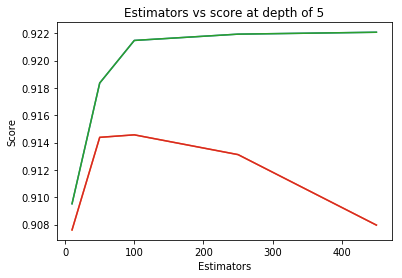

In [54]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8949603900952848 test Score 0.8741052014942736
depth =  9 Train Score 0.9360254429127565 test Score 0.9273782435689065
depth =  11 Train Score 0.9382050540742228 test Score 0.9282749447838731
depth =  15 Train Score 0.9500877674602457 test Score 0.9267378494825711
depth =  20 Train Score 0.9529872894706812 test Score 0.9259543094148095
depth =  35 Train Score 0.9535361101001514 test Score 0.9261583609015455
depth =  50 Train Score 0.9534687885463979 test Score 0.9261677119534877
depth =  70 Train Score 0.9534623667394676 test Score 0.9261637624878941
depth =  130 Train Score 0.9534623667394676 test Score 0.9261637624878941


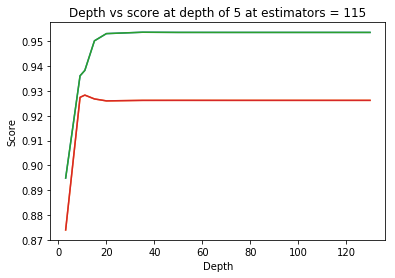

In [37]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [11]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)

import pickle
pickle.dump(rf_random,open('rf_random_2.p','wb'))

In [12]:
rf_random.grid_scores_

[mean: 0.94717, std: 0.00143, params: {'max_depth': 14, 'min_samples_leaf': 51, 'min_samples_split': 125, 'n_estimators': 117},
 mean: 0.94104, std: 0.00162, params: {'max_depth': 12, 'min_samples_leaf': 33, 'min_samples_split': 138, 'n_estimators': 109},
 mean: 0.93796, std: 0.00125, params: {'max_depth': 11, 'min_samples_leaf': 56, 'min_samples_split': 179, 'n_estimators': 106},
 mean: 0.94485, std: 0.00120, params: {'max_depth': 13, 'min_samples_leaf': 49, 'min_samples_split': 165, 'n_estimators': 108},
 mean: 0.94772, std: 0.00114, params: {'max_depth': 14, 'min_samples_leaf': 28, 'min_samples_split': 111, 'n_estimators': 121}]

In [13]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.94716991 0.94103944 0.93796448 0.94485387 0.94772461]
mean train scores [0.94719986 0.94105021 0.93797457 0.94487586 0.94775144]


In [14]:
#best estimator
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [15]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
clf.fit(df_final_train,y_train)

import pickle
pickle.dump(clf,open('clf_rf.p','wb'))

In [22]:
print('Train f1 score',f1_score(y_train,y_pred_train))
print('Test f1 score',f1_score(y_test,y_pred_test))

Train f1 score 0.9483274727305785
Test f1 score 0.926825556291337


In [18]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


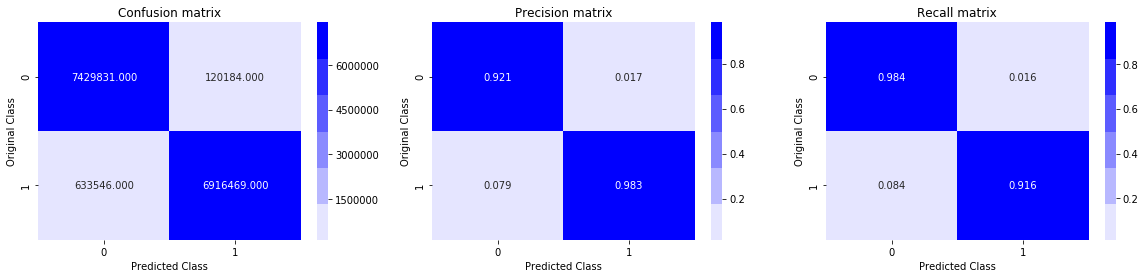

Test confusion_matrix


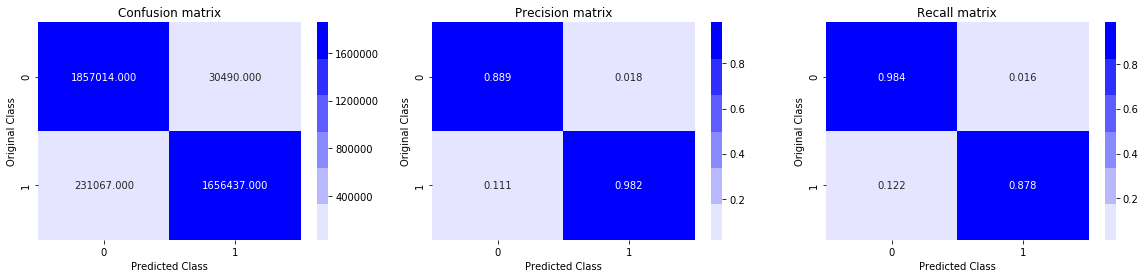

In [18]:
y_pred_train = clf.predict(df_final_train)
y_pred_test = clf.predict(df_final_test)
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_pred_train)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_pred_test)

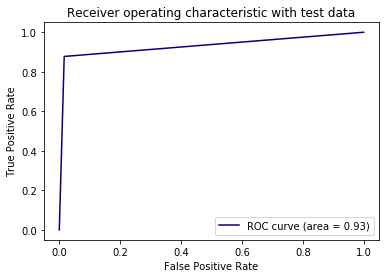

In [19]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_pred_test)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

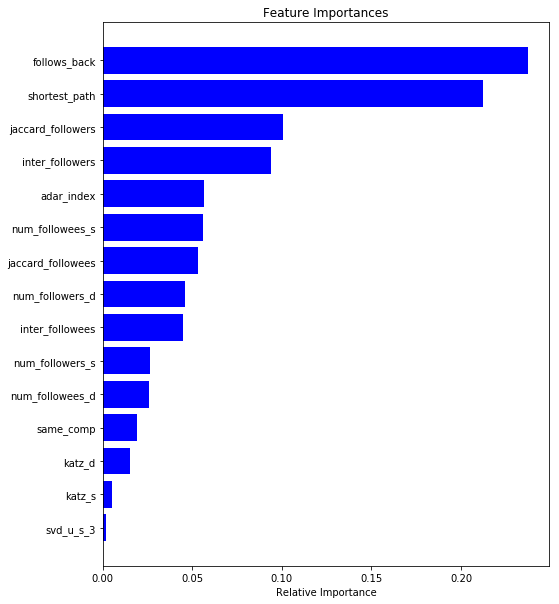

In [21]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(8,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Some other features: 

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

In [2]:
##reading data
from pandas import read_hdf
df_final_train = read_hdf('storage_final_df.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_final_df.h5', 'test_df',mode='r')

In [38]:
#Getting basic info from our data
g=nx.read_edgelist('train_data.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [39]:
from tqdm import tqdm

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [40]:
#weight for source and destination of each link
Weight_in = []
Weight_out = []
for i in  tqdm(g.nodes()):
    s1=set(g.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    s2=set(g.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_in.append((i,w_in))
    Weight_out.append((i,w_out))

100%|██████████| 1780722/1780722 [00:14<00:00, 122313.55it/s]


In [42]:
#converting as dict to map DataFrame
Weight_in_dict = dict(Weight_in)
Weight_out_dict = dict(Weight_out)

In [45]:
#saving to disk
import pickle
pickle.dump(Weight_in_dict,open('Weight_in_dict.p','wb'))
pickle.dump(Weight_out_dict,open('Weight_out_dict.p','wb'))

In [6]:
import pickle
Weight_in_dict = pickle.load(open('Weight_in_dict.p','rb'))
Weight_out_dict = pickle.load(open('Weight_out_dict.p','rb'))

In [7]:
#for imputing
mean_weight_in = np.mean(list(Weight_in_dict.values()))
mean_weight_out = np.mean(list(Weight_out_dict.values()))

In [8]:
#mapping to pandas train
df_final_train['Weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in_dict.get(x,mean_weight_in))
df_final_train['Weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out_dict.get(x,mean_weight_out))
#mapping to pandas test
df_final_test['Weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in_dict.get(x,mean_weight_in))
df_final_test['Weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out_dict.get(x,mean_weight_out))

From above derived some other features

In [9]:
#some features engineerings on tose in and out weigts
df_final_train['Weight_f1'] = df_final_train.Weight_in + df_final_train.Weight_out
df_final_train['Weight_f2'] = df_final_train.Weight_in * df_final_train.Weight_out
df_final_train['Weight_f3'] = (2*df_final_train.Weight_in + 1*df_final_train.Weight_out)
df_final_train['Weight_f4'] = (1*df_final_train.Weight_in + 2*df_final_train.Weight_out)

#some features engineerings on tose in and out weigts
df_final_test['Weight_f1'] = df_final_test.Weight_in + df_final_test.Weight_out
df_final_test['Weight_f2'] = df_final_test.Weight_in * df_final_test.Weight_out
df_final_test['Weight_f3'] = (2*df_final_test.Weight_in + 1*df_final_test.Weight_out)
df_final_test['Weight_f4'] = (1*df_final_test.Weight_in + 2*df_final_test.Weight_out)

In [11]:
df_final_train.columns

Index(['source_node', 'destination_node', 'jaccard_followers',
       'jaccard_followees', 'num_followers_s', 'num_followees_s',
       'num_followers_d', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d', 'indicator_link',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'Weight_in',
       'Weight_out', 'Weight_f1', 'Weight_f2', 'Weight_f3', 'Weight_f4'],
      dtype='object')

In [13]:
del Weight_in_dict
del Weight_out_dict

#### Some Other SVD Features:

In [14]:
#adj matrix
g=nx.read_edgelist('train_data.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
Adj = nx.adjacency_matrix(g,nodelist=sorted(g.nodes()))
Adj = Adj.asfptype()
Adj

<1780722x1780722 sparse matrix of type '<class 'numpy.float64'>'
	with 7550015 stored elements in Compressed Sparse Row format>

In [15]:
#nodes list sorted
nodes_list = list(g.nodes())
nodes_list = sorted(nodes_list)
#node and index as key value pairs, i need it because getting index from list is O(n) order
# but from dict its O(1)
nodes_list_dict = {k:v for v,k in enumerate(nodes_list)}

In [16]:
# deleting because of sapce constraint
del g
del nodes_list

In [17]:
### svd decomposition
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd_mat = svd.fit_transform(Adj)

In [18]:
# deleting because of sapce constraint
del Adj

In [19]:
import pickle
pickle.dump(svd_mat,open('svd_mat.p','wb'))
pickle.dump(nodes_list_dict,open('nodes_list_dict.p','wb'))

In [5]:
import pickle
svd_mat = pickle.load(open('svd_mat.p','rb'))
nodes_list_dict = pickle.load(open('nodes_list_dict.p','rb'))

In [21]:
#for Train
### SVD dot product of source and destination vectores
### SVD mean of source and destination vector
from tqdm import tqdm
svd_dot = []
svd_mean_dest = []
svd_mean_source = []
for idx,temp_series in tqdm(df_final_train.iterrows(),total=df_final_train.shape[0]):
    in_idx = nodes_list_dict.get(temp_series.destination_node,'X')
    out_idx = nodes_list_dict.get(temp_series.source_node,'X')
    if in_idx != 'X':
        #mean of total svd vector
        svd_mean_dest.append(np.squeeze(np.mean(svd_mat[in_idx,:])))
    else:
        svd_mean_dest.append(0)
    
    if out_idx != 'X':
        #mean of total svd vector
        svd_mean_source.append(np.squeeze(np.mean(svd_mat[out_idx,:])))
    else:
        svd_mean_source.append(0)
    
    if ( in_idx != 'X' and out_idx != 'X' ):
        #dot product of svd vector of Source and destination
        svd_temp = np.dot(svd_mat[in_idx,:],svd_mat[out_idx,:])
        svd_dot.append(svd_temp)
    else:
        svd_dot.append(0)

100%|██████████| 15100030/15100030 [16:53<00:00, 14894.68it/s]


In [22]:
import pickle
pickle.dump(svd_dot,open('svd_dot_train.p','wb'))
pickle.dump(svd_mean_source,open('svd_mean_source_train.p','wb'))
pickle.dump(svd_mean_dest,open('svd_mean_dest_train.p','wb'))

In [23]:
###mappng above features into 
df_final_train['svd_dot'] = svd_dot
df_final_train['svd_mean_s'] = svd_mean_source
df_final_train['svd_mean_d'] = svd_mean_dest

In [24]:
del svd_dot
del svd_mean_dest
del svd_mean_source

In [25]:
###for test
### SVD dot product of source and destination vectores
### SVD mean of source and destination vector
from tqdm import tqdm
svd_dot = []
svd_mean_dest = []
svd_mean_source = []
for idx,temp_series in tqdm(df_final_test.iterrows(),total=df_final_test.shape[0]):
    in_idx = nodes_list_dict.get(temp_series.destination_node,'X')
    out_idx = nodes_list_dict.get(temp_series.source_node,'X')
    if in_idx != 'X':
        svd_mean_dest.append(np.squeeze(np.mean(svd_mat[in_idx,:])))
    else:
        svd_mean_dest.append(0)
    
    if out_idx != 'X':
        svd_mean_source.append(np.squeeze(np.mean(svd_mat[out_idx,:])))
    else:
        svd_mean_source.append(0)
    
    if ( in_idx != 'X' and out_idx != 'X' ):
        svd_temp = np.dot(svd_mat[in_idx,:],svd_mat[out_idx,:])
        svd_dot.append(svd_temp)
    else:
        svd_dot.append(0)

100%|██████████| 3775008/3775008 [04:14<00:00, 14830.45it/s]


In [26]:
import pickle
pickle.dump(svd_dot,open('svd_dot_test.p','wb'))
pickle.dump(svd_mean_source,open('svd_mean_source_test.p','wb'))
pickle.dump(svd_mean_dest,open('svd_mean_dest_test.p','wb'))

In [27]:
###mappng above features into 
df_final_test['svd_dot'] = svd_dot
df_final_test['svd_mean_s'] = svd_mean_source
df_final_test['svd_mean_d'] = svd_mean_dest

In [28]:
del svd_dot
del svd_mean_dest
del svd_mean_source
del nodes_list_dict

In [32]:
#saving to db
from pandas import HDFStore,DataFrame
hdf2 = HDFStore('storage_all_features.h5')

In [33]:
#saving to disk 
hdf2.put('train_df',df_final_train, format='table', data_columns=True)

In [34]:
#saving to disk
hdf2.put('test_df',df_final_test, format='table', data_columns=True)

In [35]:
hdf2.close()

In [2]:
## reading
from pandas import read_hdf
df_final_train = read_hdf('storage_all_features.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_all_features.h5', 'test_df',mode='r')

In [3]:
#dependent varible
y_train = df_final_train.indicator_link 
y_test = df_final_test.indicator_link

In [4]:
#dropping some columns
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [5]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'Weight_in',
       'Weight_out', 'Weight_f1', 'Weight_f2', 'Weight_f3', 'Weight_f4',
       'svd_dot', 'svd_mean_s', 'svd_mean_d'],
      dtype='object')

In [6]:
df_final_test.columns

Index(['jaccard_followers', 'jaccard_followees', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'Weight_in',
       'Weight_out', 'Weight_f1', 'Weight_f2', 'Weight_f3', 'Weight_f4',
       'svd_dot', 'svd_mean_s', 'svd_mean_d'],
      dtype='object')

depth =  3 Train Score 0.924170984571304 test Score 0.9152763777461715
depth =  11 Train Score 0.9503796519459076 test Score 0.924220959419516
depth =  15 Train Score 0.9590027669458241 test Score 0.9245986302407551
depth =  25 Train Score 0.9630456634334905 test Score 0.9236317354926886
depth =  35 Train Score 0.9632218097809785 test Score 0.9236077277146334
depth =  50 Train Score 0.9632496325083799 test Score 0.9233378118527031
depth =  100 Train Score 0.9632496325083799 test Score 0.9233378118527031


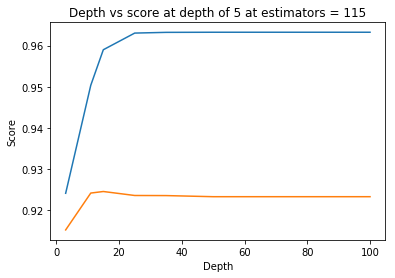

In [7]:
depths = [3,11,15,25,35,50,100]
train_scores = []
test_scores = []

for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [8]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,17),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65),
             "max_features":['auto',11]}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf,param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)

print(rf_random.grid_scores_)

print()

print(rf_random.cv_results_)

import pickle
pickle.dump(rf_random,open('rf_random_final.p','wb'))

In [10]:
rf_random.grid_scores_

[mean: 0.95251, std: 0.00109, params: {'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 51, 'min_samples_split': 125, 'n_estimators': 117},
 mean: 0.95499, std: 0.00083, params: {'max_depth': 12, 'max_features': 11, 'min_samples_leaf': 33, 'min_samples_split': 138, 'n_estimators': 109},
 mean: 0.95229, std: 0.00054, params: {'max_depth': 11, 'max_features': 11, 'min_samples_leaf': 56, 'min_samples_split': 179, 'n_estimators': 106},
 mean: 0.95015, std: 0.00092, params: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 28, 'min_samples_split': 155, 'n_estimators': 108},
 mean: 0.94129, std: 0.00128, params: {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 56, 'min_samples_split': 158, 'n_estimators': 120}]

In [11]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.95250539 0.95498837 0.95228519 0.95015108 0.94129217]
mean train scores [0.95258963 0.95503648 0.95233589 0.95022736 0.94129525]


In [12]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=33, min_samples_split=138,
            min_weight_fraction_leaf=0.0, n_estimators=109, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [13]:
clf_1 =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=33, min_samples_split=138,
            min_weight_fraction_leaf=0.0, n_estimators=109, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
clf_1.fit(df_final_train,y_train)

import pickle
pickle.dump(clf_1,open('clf2_1.p','wb'))

In [6]:
clf_1 = pickle.load(open('/home/u19292/clf2_1.p','rb'))

In [7]:
y_train_pred1 = clf_1.predict(df_final_train)
y_test_pred1 = clf_1.predict(df_final_test)

In [29]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred1))
print('Test f1 score',f1_score(y_test,y_test_pred1))

Train f1 score 0.9550800890664483
Test f1 score 0.9243521371699511


In [8]:
df_final_test1 = read_hdf('storage_all_features.h5', 'test_df',mode='r')

In [9]:
train_nodes_pos = pickle.load(open('train_nodes_pos.p','rb'))

In [32]:
from tqdm import tqdm
count_error  = 0
count_cold_err = 0
total_cold_nodes = 0
for i,row in tqdm(df_final_test1.iterrows(),total=df_final_test1.shape[0]):
    if row['source_node'] not in train_nodes_pos or row['destination_node'] not in train_nodes_pos:
        total_cold_nodes = total_cold_nodes + 1    
        if y_test.values[i] != y_test_pred1[i]:
            count_error = count_error + 1
            count_cold_err = count_cold_err + 1
    else:
        if y_test.values[i] != y_test_pred1[i]:
            count_error = count_error + 1 

100%|██████████| 3775008/3775008 [02:07<00:00, 29524.56it/s]


In [35]:
print('Length of Total Test data',len(df_final_test1))
print('Total no of errors in test data',count_error)
print('Leghth of test data where any one of nodes are not there in Train',total_cold_nodes)
print('Total no of error Where any one of nodes are not there in Train',count_cold_err)

Length of Total Test data 3775008
Total no of errors in test data 271739
Leghth of test data where any one of nodes are not there in Train 253173
Total no of error Where any one of nodes are not there in Train 91728


In [41]:
print('Total Error is {}%'.format(count_error/len(df_final_test1)*100))
print('Error Where nodes not in Train Data is {}%'.format(count_cold_err/len(df_final_test1)*100))

Total Error is 7.198368851138859%
Error Where nodes not in Train Data is 2.429875645296646%


Train confusion_matrix


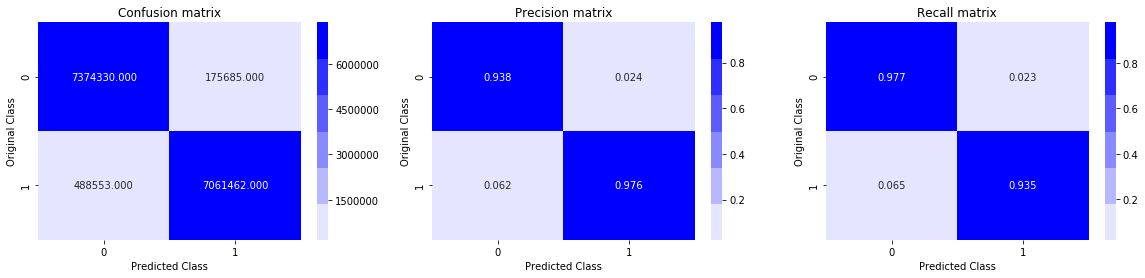

Test confusion_matrix


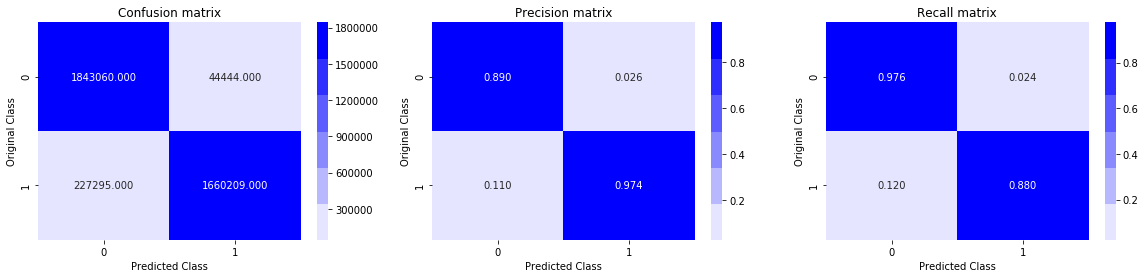

In [30]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred1)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred1)

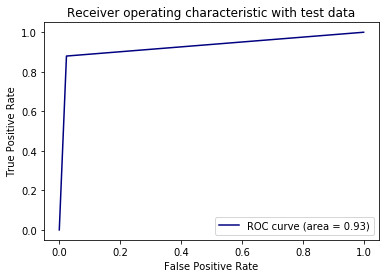

In [31]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred1)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

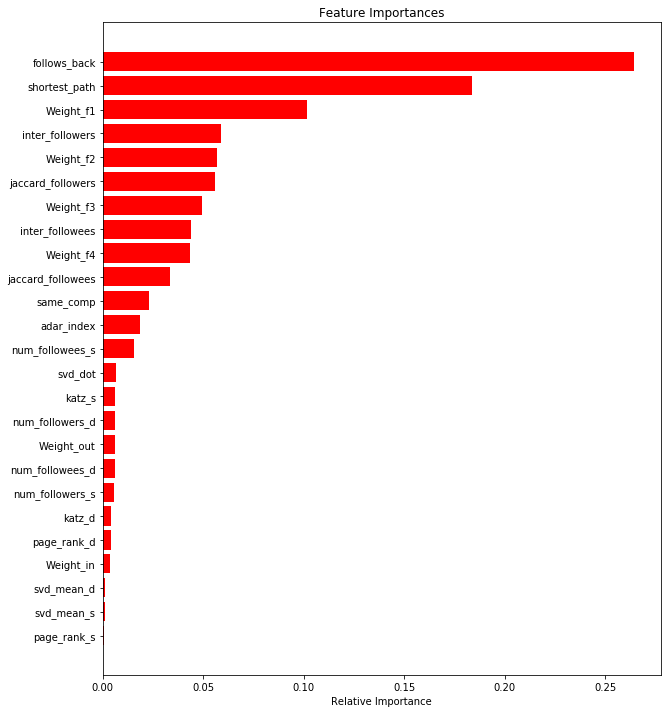

In [32]:
features = df_final_train.columns
importances = clf_1.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

improved some score and we can observe that Weight features and svd dot produts is somewhat better features than so many features. 

In [34]:
feature_importances = pd.DataFrame(clf_1.feature_importances_,index = df_final_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
follows_back,2.644804e-01
shortest_path,1.838595e-01
Weight_f1,1.016269e-01
inter_followers,5.900783e-02
Weight_f2,5.704880e-02
jaccard_followers,5.575706e-02
Weight_f3,4.926787e-02
inter_followees,4.368723e-02
Weight_f4,4.320862e-02
jaccard_followees,3.365333e-02
